#### Data Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from dmba import classificationSummary
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

Code in the Data Preprocessing section has been developed with the help of: <br> 
OpenAI. (2023). ChatGPT. (August 3 Version) [Large language model]. https://chat.openai.com/chat

In [2]:
# Import the dataset
telco = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
# View the dataset
telco

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# Remove customerID column since it is an irreleavnt predictor of churn
telco.drop('customerID', axis=1, inplace=True)

In [5]:
# Replace 0 with 'No' and 1 with 'Yes' in the SeniorCitizen column to align boolean representation with rest of the dataset.
telco['SeniorCitizen'] = telco['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [6]:
# Check the column data types
telco.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
# Convert the TotalCharges column from object to float64 data type
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'], errors='coerce')

# Convert all object-type columns to categorical data type
categorical_columns = telco.select_dtypes(include='object').columns
telco[categorical_columns] = telco[categorical_columns].astype('category')

In [8]:
telco.dtypes

gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

In [9]:
# Check columns for missing values
telco.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

It appears that there are 11 missing values in the TotalCharges column. 

It was observed that the TotalCharges column is approximately equal to the product of the tenure and MonthlyCharges columns. This suggests that the TotalCharges variable itself is not an independent predictor of churn. As expected, it is highly correlated with tenure and MonthlyCharges, as can be seen in the correlation matrix below.

In [10]:
# Select only numeric columns
numeric_columns = telco.select_dtypes(include='number').columns

# Create the correlation matrix
correlation_matrix = telco[numeric_columns].corr()

# Print the correlation matrix
print(correlation_matrix)

                 tenure  MonthlyCharges  TotalCharges
tenure          1.00000        0.247900      0.825880
MonthlyCharges  0.24790        1.000000      0.651065
TotalCharges    0.82588        0.651065      1.000000


Since the TotalCharges variable is not an independent predictor of churn, it will be removed from the dataset.

In [11]:
# Remove TotalCharges column since it is not an independent predictor of churn
telco.drop('TotalCharges', axis=1, inplace=True)

In [12]:
# Confirm that there are no missing values in the dataset
telco.isnull().any().any()

False

A False value confirms that are no missing values in the dataset.

In [13]:
# Check if there is duplicate data
telco.duplicated().any()

True

In [14]:
# Count number of duplicate rows
telco[telco.duplicated() == True].shape[0]

27

In [15]:
# Rows in dataset before dropping duplicate rows
telco.shape[0]

7043

In [16]:
# Remove duplicate rows
telco.drop_duplicates(inplace = True)

In [17]:
# Rows in dataset after removing duplicate rows
telco.shape[0]

7016

In [18]:
# Confirm that there is no duplicate data
telco.duplicated().any()

False

A False value confirms that there's no duplicated data.

In [19]:
# Check if there's any column that has no variation: a column that contains a single unique value
any(telco[column].nunique() <= 1 for column in telco.columns)

False

A False value confirms that all columns have some variation in values.

In [20]:
# Check unique values for every categorical variable to ensure that there are no incorrect values.
categorical_columns = telco.select_dtypes(include='category').columns
for col in categorical_columns:
    unique_values = telco[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'gender': ['Female', 'Male']
Categories (2, object): ['Female', 'Male']
Unique values in 'SeniorCitizen': ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Unique values in 'Partner': ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
Unique values in 'Dependents': ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Unique values in 'PhoneService': ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Unique values in 'MultipleLines': ['No phone service', 'No', 'Yes']
Categories (3, object): ['No', 'No phone service', 'Yes']
Unique values in 'InternetService': ['DSL', 'Fiber optic', 'No']
Categories (3, object): ['DSL', 'Fiber optic', 'No']
Unique values in 'OnlineSecurity': ['No', 'Yes', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
Unique values in 'OnlineBackup': ['Yes', 'No', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
Unique values in 'DeviceProtection': ['No', 'Yes', 'No internet servi

After manual checking of the unique values, it was observed that there are no incorrect values in any of the categorical variables.

In [21]:
# Calculate summary statistics to check numeric columns for incorrect data
telco.describe()

,tenure,MonthlyCharges
count,7016.000000,7016.000000
mean,32.462087,64.869897
std,24.526687,30.055654
min,0.000000,18.250000
25%,9.000000,35.750000
50%,29.000000,70.400000
75%,55.000000,89.900000
max,72.000000,118.750000


Values in the numeric columns are error-free: all values are positive and min-max values are within expected range. This information can be further verified from the box plots below, which also show that there are no outliers in the dataset.
<br><br> 
Overall, there are no incorrect values in the dataset.

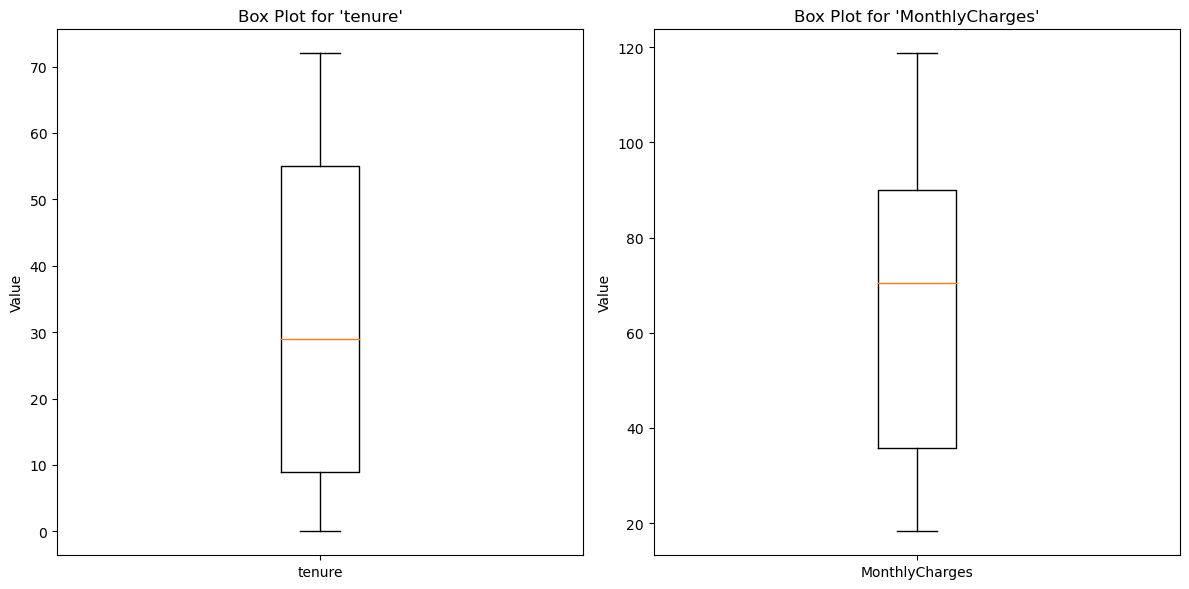

In [22]:
# Create box plots for numeric columns to detect outliers
# Select only numeric columns
numeric_columns = telco.select_dtypes(include='number').columns

# Create separate box plots for each numeric column
plt.figure(figsize=(12, 6))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)
    plt.boxplot(telco[column])
    plt.title(f"Box Plot for '{column}'")
    plt.ylabel("Value")
    
    # Set x-axis tick labels to the column names
    plt.xticks([1], [column])

plt.tight_layout()
plt.show()

The summary statistics and box plots for the numeric variables reveal that 'tenure' ranges from 0 to 72 months, while 'MonthlyCharges' range from 18.25 to 118.75 dollars. The scales of both variables are not drastically different from each other. Therefore, it is not necessary to rescale them.

In order to get the data ready for training, the categorical variables will be transformed to numeric through label encoding. One-hot encoding is not desirable because it will lead to a huge increase in the number of variables, which can negatively affect model performance. 

In [23]:
# Select only categorical columns
categorical_columns = telco.select_dtypes(include='category').columns

# Label Encoding for categorical variables
label_encoder = LabelEncoder()
telco[categorical_columns] = telco[categorical_columns].apply(label_encoder.fit_transform)

In [24]:
telco

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,1


The data is ready for training. At this stage, it is believed that all remaining variables are relevant predictors of churn. The goal is to maximize model accuracy, so all variables will be considered. Feature selection or dimensionality reduction may be explored at a later stage for comparing trade-off between model accuracy and model complexity. 

In [25]:
# Split predictor and target variables
X = telco.drop(columns='Churn')
y = telco['Churn']

In [26]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [27]:
# Print the number of records in the dataset, training set and test set
print("Number of records in dataset:", X_train.shape[0]+ X_test.shape[0])
print("Number of records in training set:", X_train.shape[0])
print("Number of records in test set:", X_test.shape[0])

Number of records in dataset: 7016
Number of records in training set: 4209
Number of records in test set: 2807


# Decision Tree

In [28]:
# define AUC to be the performance metric for grid search
scoring = {'auc': make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")}

In [29]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(5,10)),
    'min_samples_split': [100, 110, 120, 130],
    'min_samples_leaf': [20, 30, 40],
    'max_leaf_nodes': [25, 30, 35],
    }
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, scoring = scoring, refit = 'auc', cv=5,
n_jobs=-1) 
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_

#source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#source: OpenAI. (2023). ChatGPT. (August 3 Version) [Large language model]. https://chat.openai.com/chat

Improved score:  0.8261444162792071
Improved parameters:  {'max_depth': 6, 'max_leaf_nodes': 30, 'min_samples_leaf': 40, 'min_samples_split': 130}


In [30]:
# Creating the model:
decTree = DecisionTreeClassifier(random_state=42, **gridSearch.best_params_)

#source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#source: OpenAI. (2023). ChatGPT. (August 3 Version) [Large language model]. https://chat.openai.com/chat

In [31]:
# Training the model:
decTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=30, min_samples_leaf=40,
                       min_samples_split=130, random_state=42)

In [32]:
# Predicting using the test data:
y_pred = decTree.predict(X_test)

#source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [33]:
print('\nClassification Report:\n', classification_report(y_test, y_pred, zero_division=1))


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      2078
           1       0.61      0.43      0.51       729

    accuracy                           0.78      2807
   macro avg       0.72      0.67      0.68      2807
weighted avg       0.77      0.78      0.77      2807



In [34]:
classificationSummary(y_test, y_pred)

Confusion Matrix (Accuracy 0.7820)

       Prediction
Actual    0    1
     0 1880  198
     1  414  315


In [35]:
#Extract Accuracy score for each model above:
acc_dt = accuracy_score(y_test, y_pred).round(2)
acc_dt

0.78

# Logistic Regression

In [36]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_test)

#Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [37]:
# Define the hyperparameters to search over
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['liblinear'],
              'max_iter': [100, 500, 1000]}

#Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html

In [38]:
# Create logistic regression model and fit to training data using GridSearchCV
lr_model = LogisticRegression()
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [39]:
# Print the best hyperparameters and the corresponding accuracy score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7982940792688266


In [40]:
# Create a new logistic regression model with the best hyperparameters and fit to training data
lr_model = LogisticRegression(**grid_search.best_params_)
lr_model.fit(X_train, y_train)

#Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LogisticRegression(C=0.01, solver='liblinear')

In [41]:
# Make predictions on test data
y_pred = lr_model.predict(X_test)

In [42]:
# Calculate accuracy score and print classification report
acc_score = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)
print('Accuracy Score:', acc_score)
print('\nClassification Report:\n', class_report)

Accuracy Score: 0.8029925187032418

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      2078
           1       0.65      0.53      0.59       729

    accuracy                           0.80      2807
   macro avg       0.75      0.72      0.73      2807
weighted avg       0.79      0.80      0.80      2807



In [43]:
# Calculate accuracy score with a confusion matrix
classificationSummary(y_test, y_pred)

Confusion Matrix (Accuracy 0.8030)

       Prediction
Actual    0    1
     0 1864  214
     1  339  390


In [44]:
#Extract Accuracy score for each model above:
acc_lr = accuracy_score(y_test, y_pred).round(2)
acc_lr

0.8

# KNN

In [45]:
#square root of 7016 is 83 however it would be too large so we will try half of it.
#Different k values were tested until obtaining the best result, the range value based on dataset size - since it is a larger data set, a larger range was used.
results = []
for k in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test))
    })

results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.730673
1    2  0.764161
2    3  0.762736
3    4  0.778055
4    5  0.775205
5    6  0.789455
6    7  0.781974
7    8  0.786961
8    9  0.786605
9   10  0.790167
10  11  0.785180
11  12  0.786961
12  13  0.781261
13  14  0.783042
14  15  0.781974
15  16  0.779480
16  17  0.781617
17  18  0.783399
18  19  0.781261
19  20  0.786605
20  21  0.789455
21  22  0.788742
22  23  0.787674
23  24  0.789811
24  25  0.788030
25  26  0.788030
26  27  0.788030
27  28  0.790167
28  29  0.790524
29  30  0.790167
30  31  0.789455
31  32  0.788386
32  33  0.788386
33  34  0.787674
34  35  0.790524
35  36  0.786961
36  37  0.785180
37  38  0.784111
38  39  0.785536
39  40  0.784824


In [46]:
# See the highest result 5 results
top_5 = results.sort_values(by='accuracy', ascending=False).head(5)
print(top_5)

     k  accuracy
34  35  0.790524
28  29  0.790524
27  28  0.790167
9   10  0.790167
29  30  0.790167


In [47]:
# Create KNN classifier
telco_knn = KNeighborsClassifier(n_neighbors = 35) #odd values are suggested to use for binary classification problems 
#Resource - https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/#:~:text=KNN%20for%20Classification&text=If%20you%20are%20using%20K,an%20odd%20number%20of%20classes.

# Fit the classifier to the data
telco_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=35)

In [48]:
y_pred = telco_knn.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2078
           1       0.63      0.47      0.54       729

    accuracy                           0.79      2807
   macro avg       0.73      0.69      0.70      2807
weighted avg       0.78      0.79      0.78      2807



In [50]:
#telco confusion matrix
classificationSummary(y_test, y_pred)

Confusion Matrix (Accuracy 0.7905)

       Prediction
Actual    0    1
     0 1876  202
     1  386  343


In [51]:
#Extract Accuracy score for each model above:
acc_knn = accuracy_score(y_test, y_pred).round(2)
acc_knn

0.79

In [52]:
# set up data for plotting accuracy scores of all models
acc_scores = {'Decision Tree': acc_dt, 'Logistic Regression': acc_lr,
                   'K-Nearest Neighbors': acc_knn}

# sorted data in descending order
sorted_acc_scores = {k: v for k, v in sorted(acc_scores.items(), key=lambda item: item[1], reverse=True)}
sorted_acc_scores

{'Logistic Regression': 0.8,
 'K-Nearest Neighbors': 0.79,
 'Decision Tree': 0.78}

[Text(0, 0, '0.8'), Text(0, 0, '0.79'), Text(0, 0, '0.78')]

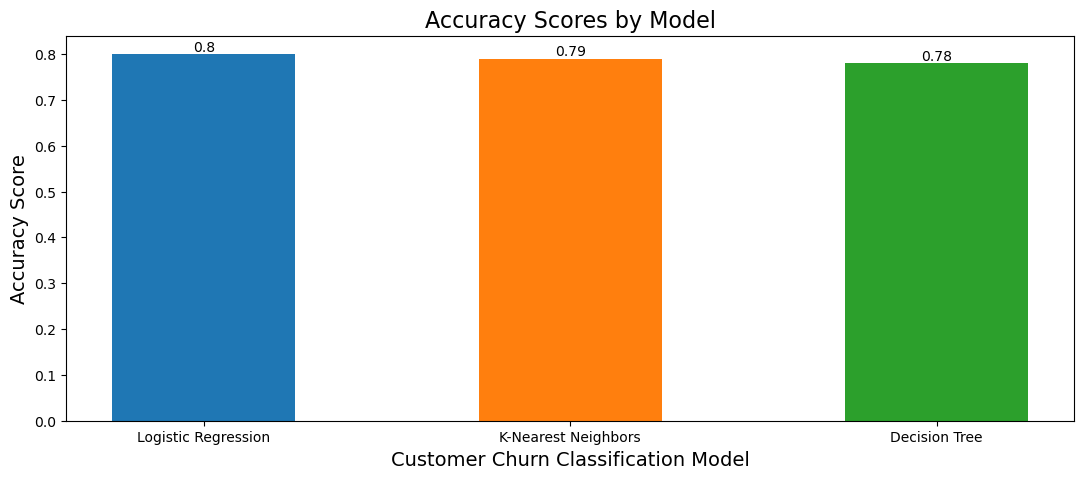

In [53]:
fig, ax = plt.subplots(figsize=(13, 5))
color_set = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose your desired colors
bar_width = 0.5  # Adjust the width as per your preference

bars = ax.bar(sorted_acc_scores.keys(), sorted_acc_scores.values(), width=bar_width, color=color_set)
ax.set_xlabel('Customer Churn Classification Model', fontsize=14)
ax.set_ylabel('Accuracy Score', fontsize=14)
ax.set_title('Accuracy Scores by Model', fontsize=16)
ax.bar_label(bars)